In [1]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional,Attention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
!nvidia-smi

Fri Jul  7 04:17:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
train_dir = '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train'
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/cataract'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/diabetes'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/amd'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/normal'.


In [37]:
test_dir = '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid'
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/amd'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/normal'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/diabetes'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/cataract'.


In [6]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (1749, 1839, 3)


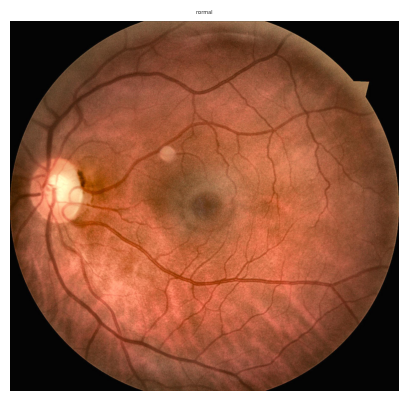

In [38]:
img = view_random_image(target_dir='/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/',
                        target_class="normal")

In [8]:
EPOCHS = 100
IMAGE_SIZE = 256
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1

In [9]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def augment_image(image, label):
    # Apply augmentation transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Apply the width and height shifts
    width_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[1], tf.float32)
    height_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[0], tf.float32)
    image = tfa.image.translate(image, [width_shift, height_shift])

    return image, label

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=[IMAGE_SIZE, IMAGE_SIZE])
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=[IMAGE_SIZE, IMAGE_SIZE],
                                                                shuffle=False)

Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


In [11]:
# Apply augmentation to the training dataset using the map function
train_dataset_augmented = train_data.map(augment_image)

In [12]:
def create_model():

    # Input layer
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # 1st conv block
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(inputs)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 2nd conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 3rd conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 4th conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 5th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 6th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=True, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
#     x = AveragePooling2D(pool_size=(4, 4))(x)

    # LSTM layer
    x = Reshape((16, 512))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # FC layer
    x = Flatten(name="flatten")(x)
    x = Dense(units=64, activation='relu')(x)
    x = BatchNormalization()(x)
#    x = Dropout(0.2)(x)

    # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    opt = Adam(learning_rate=1e-3)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])

    return model

# Create an instance of the model
model = create_model()

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496 

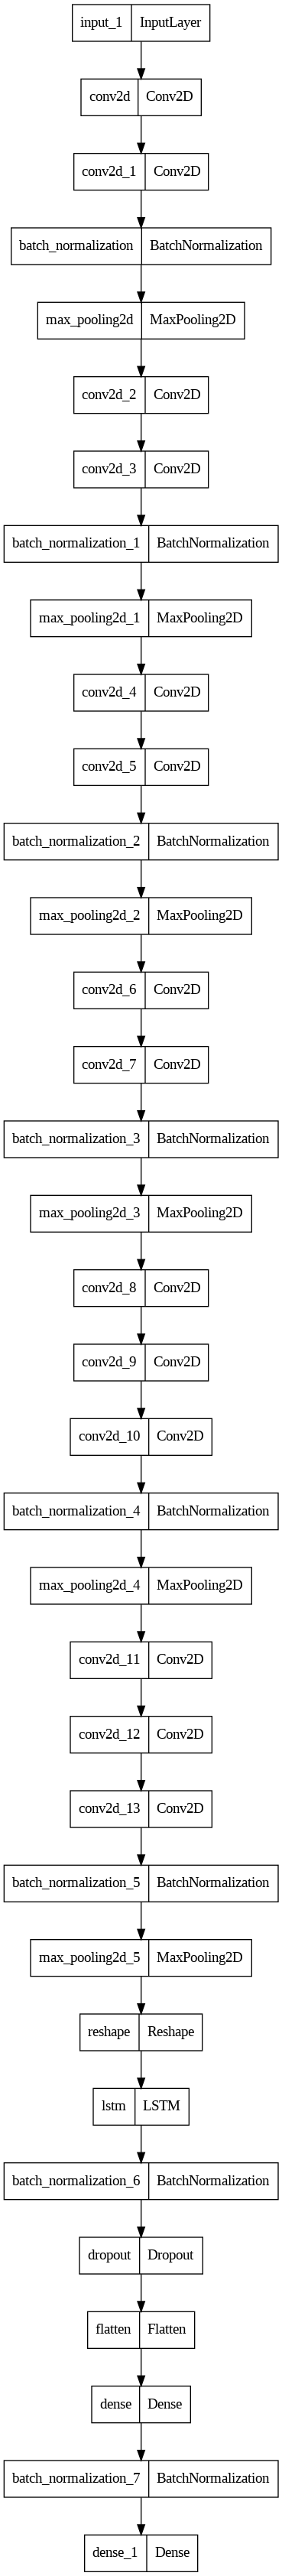

In [20]:
plot_model(model, to_file='model.png')

In [13]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step)))]
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=15, verbose=1, mode='max')
csv_logger = CSVLogger('/content/learningRate.csv')

In [14]:
history = model.fit(train_dataset_augmented,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data = test_data,
                    callbacks=[checkpoint,csv_logger])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.3744
Epoch 1: val_accuracy improved from -inf to 0.24000, saving model to best_model.h5
50/50 [==============================] - 233s 4s/step - loss: 1.4035 - accuracy: 0.3744 - val_loss: 5.1521 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 1.0468 - accuracy: 0.5019
Epoch 2: val_accuracy improved from 0.24000 to 0.29000, saving model to best_model.h5
50/50 [==============================] - 39s 718ms/step - loss: 1.0468 - accuracy: 0.5019 - val_loss: 1.4676 - val_accuracy: 0.2900 - lr: 9.5000e-04
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.9491 - accuracy: 0.5975
Epoch 3: val_accuracy did not improve from 0.29000
50/50 [==============================] - 39s 699ms/step - loss: 0.9491 - accuracy: 0.5975 - val_loss: 2.1322 - val_accuracy: 0.2500 - lr: 9.0250e-04
Epoch 4/100
50/50 [==============================] - E

In [15]:
model.load_weights('/content/best_model.h5')
_, accuracy = model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 5s 385ms/step - loss: 0.0985 - accuracy: 0.9700
Validation accuracy: 97.0%


In [16]:
pred_probs = model.predict(test_data, verbose=1)

13/13 [==============================] - 6s 416ms/step


In [17]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [18]:
target_names = ['amd', 'cataract', 'diabetes','normal']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

         amd     0.9615    1.0000    0.9804       100
    cataract     1.0000    0.9900    0.9950       100
    diabetes     0.9684    0.9200    0.9436       100
      normal     0.9510    0.9700    0.9604       100

    accuracy                         0.9700       400
   macro avg     0.9702    0.9700    0.9698       400
weighted avg     0.9702    0.9700    0.9698       400



In [29]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Spesificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 100
False Positives: 0
True Negatives: 296
False Negatives: 4
Spesificity: 1.0
Sensitivity: 0.9615384615384616


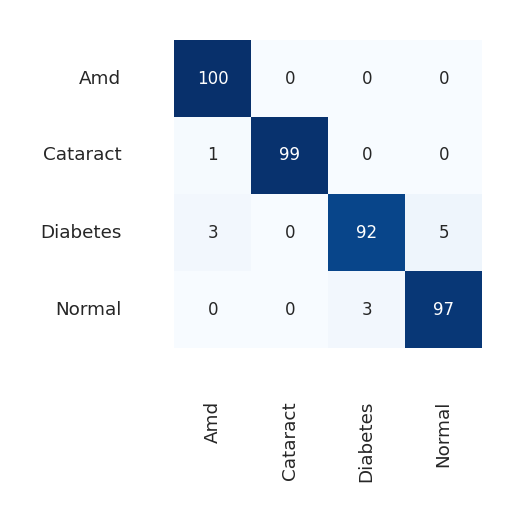

In [33]:
# Compute confusion matrix
import seaborn as sns
cnf_matrix = confusion_matrix(y_labels,
                              pred_classes)
np.set_printoptions(precision=5)

x_axis_labels = ['Amd', 'Cataract','Diabetes', 'Normal']
y_axis_labels = ['Amd', 'Cataract', 'Diabetes','Normal']
plt.figure(figsize=(1,1), dpi=400)
sns.set(font_scale=0.3)
b = sns.heatmap(cnf_matrix, annot=True, square = True,
            cbar=False, cmap='Blues',
            annot_kws={'size': 3},
            fmt='g',
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

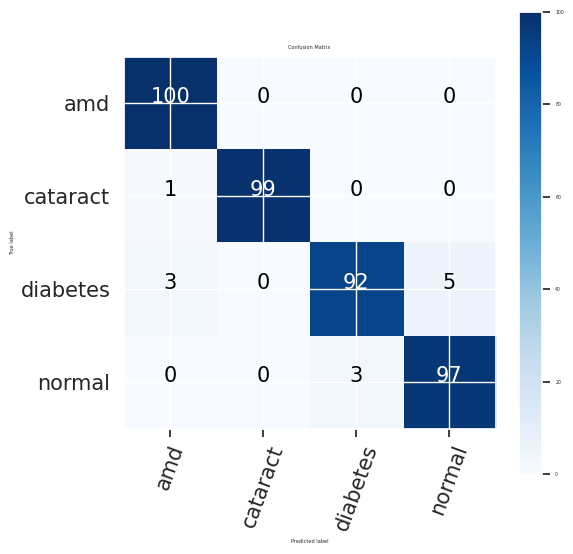

In [35]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(6, 6),
                      text_size=15,
                      norm=False,
                      savefig=True)

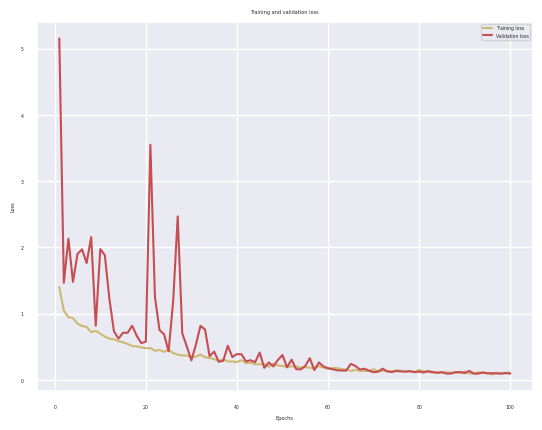

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

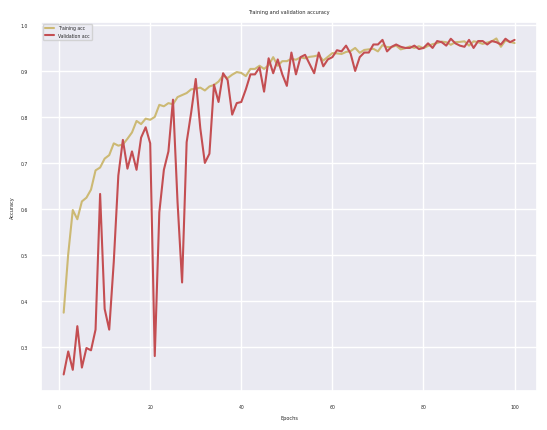

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()